# An example of using code and repeating experiments

## Environment setup



### Clone github repo

In [ ]:
!git clone https://github.com/sofi12321/SCLCM.git


### Move to SCLCM/src and setup the path

In [ ]:
%cd /content/SCLCM/src
import sys
sys.path.insert(0, '/content/SCLCM/src')

!mkdir model_weights
!mkdir outputs

/content/SCLCM/src


### Set seed for random operations

In [ ]:
from utils.imports import set_seed
set_seed(21)

### Load data

This work used 2 open source datasets - SEED and DEAP.

\\

SEED is available via

https://bcmi.sjtu.edu.cn/home/seed/

Please put data in the folder SCLCM/src/EEG_Dataset/SEED/

\\

DEAP is available via

https://www.eecs.qmul.ac.uk/mmv/datasets/deap/

Please put data in the folder SCLCM/src/EEG_Dataset/DEAP/


In [ ]:
# Example how to reformat data
# to the shape (n_subjects*n_trials*n_stimulus, 1, n_channels, time_len).

# For SEED dataset
from data.seed.reformat import reformat_seed
# data, session_labels, pid_video, num_video, subj_list, video_list, channels = reformat_seed(r"EEG_Dataset/SEED/")

# For DEAP dataset
from data.deap.reformat import reformat_deap
# data, session_labels, pid_video, num_video, subj_list, video_list, channels = reformat_deap(r"EEG_Dataset/DEAP/")


In [ ]:
# Then one could apply feature extraction techniques
from data.general.feature_extraction import extract_de, compute_psd, extract_dasm, extract_rasm, extract_dcau, reshape_3d, subtract_baseline

In [ ]:
# Also, you could ask authors for samples of preprocessed data.
# To use it, please, add the given folder to the root of your drive as a shortcut

from google.colab import drive
drive.mount("/content/drive")
!cp -r /content/drive/MyDrive/EEG_Dataset /content/SCLCM/src/

Mounted at /content/drive


In [ ]:
# Select metadata for the particular dataset and its prerocessing technique
from data.general.metadata import general_metadata, datasets_metadata

# Parameters could be changed to vary the loading data
general_metadata["batch_size"] = 256
general_metadata

{'batch_size': 256,
 'additional_processing': None,
 'spatial_transform': False,
 'augmentations': ['frequency_noise', 'mask_channel', 'mix_dtpts'],
 'split_by': 'subject',
 'test_fraction': 0.3}

In [ ]:
# Select one of the option
list(datasets_metadata.keys())

['seed_raw',
 'seed_baseline',
 'seed_de',
 'seed_baseline_de',
 'seed_psd',
 'seed_baseline_psd',
 'deap_raw',
 'deap_baseline',
 'deap_de',
 'deap_baseline_de',
 'deap_psd',
 'deap_baseline_psd']

In [ ]:
# Example
selection = "seed_de"
dataset_metadata = datasets_metadata[selection]
dataset_metadata

{'data_path': 'EEG_Dataset/SEED/seed_de_new.dat',
 'num_channels': 62,
 'data_shape': (-1, 62, 5, 288),
 'move_axis': [2, 1],
 'time_len': 250,
 'pos_groupping': 'trial',
 'need_norm': True,
 'in_channels': 5,
 'in_features': 119040,
 'num_classes': 3}

In [ ]:
# You can select channels
# Important: this could not be applied with spatial_transform
# Additionally, it requires change of the in_features parameter

# channels_cut = None

channels_cut = ['T7', 'T8']
in_features=15872

In [ ]:
# Then load the data using selected metadata
from data.general.load_any_data import load_data_by_selection
res = load_data_by_selection(selection, general_metadata, dataset_metadata, channels_cut)
data, session_labels, pid_video, num_video, subj_list, video_list, channels, need_norm, in_channels, in_features, num_classes, num_channels = res
data.shape, session_labels.shape, pid_video.shape, num_video

((675, 5, 2, 250), (675,), (675,), 15)

In [ ]:
# Additionally, different number of channels require change of the in_features parameter
in_features=15872

#### Train test split

In [ ]:
# Make loaders. pt for pretraining, ft for finetuning (without augmentations and special batching)
from data.general.train_test_split import split_data
train_loader_pt, test_loader_pt, train_loader_ft, test_loader_ft = split_data(
    data, session_labels, pid_video,
    num_video, subj_list, video_list,
    need_norm = need_norm, add_data = None, batch_size = general_metadata["batch_size"],
    augmentations = general_metadata["augmentations"],
    split_by=general_metadata["split_by"], test_fraction=general_metadata["test_fraction"])

135
Labels
Train (array([-1,  0,  1]), array([180, 180, 180]))
Test (array([-1,  0,  1]), array([45, 45, 45]))
Too low number of channels, so drop mask_channel augmentation


## Run experiment

### Model loading

In [ ]:
# To separate experiments trial and save weights (not to overwrite them)
num_exp = 'seed_de_ssl_subject'

In [ ]:
import torch
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from models.cnn.encoder import SmallCNN1d, SmallCNN2d

# Base encoder
emb_dim = 128
# model = SmallCNN2d(emb_dim,  in_channels=in_channels, in_features=in_features)
# Model with lowered kernel size
model = SmallCNN1d(emb_dim,  in_channels=in_channels, in_features=in_features  )
model

SmallCNN1d(
  (cn): Sequential(
    (0): Conv2d(5, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(64, 128, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.25, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=15872, out_features=128, bias=True)
    (12): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

### Pretext task

In [ ]:
from torch import optim
from utils.losses import HardSoftLoss

finetuning_epochs = 200
finetuning_wait_epochs = 25
sensitivity_early_stop = 1.00001
sensitivity_save_weights = 1.00001
save_weights_path = "model_weights/"
save_pt_model_path = "model_weights/cnn_pt_"+num_exp+".pth"

optimizer = optim.Adam(model.parameters(), lr=0.0001)
pt_scheduler = None
# pt_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="exp_range",gamma=0.85)
finetuning_criterion = HardSoftLoss(pos=0.4, hard_neg=0.4, soft_person_neg=0.4, soft_video_neg=0.1, num_video=num_video, device=device)

model = model.to(device)
print(num_video)

15


In [ ]:
from utils.test_run_embedding import run_embedding
import numpy as np

_, losses, pt_train_time, pt_test_time = run_embedding(device,save_pt_model_path, model,
                   train_loader_pt, test_loader_pt,
                   optimizer, finetuning_criterion,

                   finetuning_epochs, finetuning_wait_epochs,
                   sensitivity_early_stop = sensitivity_early_stop,
                   sensitivity_save_weights = sensitivity_save_weights,
                   pt_scheduler =pt_scheduler)
# Print statistics
print()
print("First loss is", round(losses[0], 4))
print("Best loss is", round(min(losses), 4), "at epoch", np.argmin(losses))
print("Train time", round(pt_train_time, 3), "Test time",  round(pt_test_time, 3))
# Save overfitted model
torch.save(model.state_dict(), save_weights_path + "cnn_ovpt_"+num_exp+".pth")

100%|██████████| 2/2 [00:00<00:00,  3.82it/s, Loss=1.154865]


Test set: Average loss: 1.1548649072647095
Epoch 1
Train loss: 0.521463


100%|██████████| 2/2 [00:00<00:00, 23.86it/s, Loss=0.692886]

Test set: Average loss: 0.6928859353065491
The model weights were saved
Epoch 2


Train loss: 0.515487


100%|██████████| 2/2 [00:00<00:00, 23.45it/s, Loss=0.625866]

Test set: Average loss: 0.625865638256073
The model weights were saved
Epoch 3


Train loss: 0.512104


100%|██████████| 2/2 [00:00<00:00, 21.54it/s, Loss=0.578919]

Test set: Average loss: 0.5789185166358948
The model weights were saved
Epoch 4


Train loss: 0.506010


100%|██████████| 2/2 [00:00<00:00, 24.51it/s, Loss=0.555862]

Test set: Average loss: 0.5558615624904633
The model weights were saved
Epoch 5


Train loss: 0.502316


100%|██████████| 2/2 [00:00<00:00, 24.55it/s, Loss=0.547076]

Test set: Average loss: 0.5470757782459259
The model weights were saved
Epoch 6


Train loss: 0.501361


100%|██████████| 2/2 [00:00<00:00, 24.22it/s, Loss=0.540941]

Test set: Average loss: 0.540941059589386
The model weights were saved
Epoch 7


Train loss: 0.498825


100%|██████████| 2/2 [00:00<00:00, 24.42it/s, Loss=0.536419]

Test set: Average loss: 0.5364187359809875
The model weights were saved
Epoch 8


Train loss: 0.498722


100%|██████████| 2/2 [00:00<00:00, 22.49it/s, Loss=0.535022]

Test set: Average loss: 0.5350217223167419
The model weights were saved
Epoch 9


Train loss: 0.495552


100%|██████████| 2/2 [00:00<00:00, 24.77it/s, Loss=0.534344]

Test set: Average loss: 0.534343957901001
The model weights were saved
Epoch 10


Train loss: 0.493704


100%|██████████| 2/2 [00:00<00:00, 24.01it/s, Loss=0.533773]

Test set: Average loss: 0.5337726175785065
The model weights were saved
Epoch 11


Train loss: 0.490337


100%|██████████| 2/2 [00:00<00:00, 18.28it/s, Loss=0.534115]

Test set: Average loss: 0.534114807844162
Epoch 12


Train loss: 0.488190


100%|██████████| 2/2 [00:00<00:00, 17.78it/s, Loss=0.533187]

Test set: Average loss: 0.5331871807575226
The model weights were saved
Epoch 13


Train loss: 0.478645


100%|██████████| 2/2 [00:00<00:00, 17.14it/s, Loss=0.533042]

Test set: Average loss: 0.5330420732498169
The model weights were saved
Epoch 14


Train loss: 0.487058


100%|██████████| 2/2 [00:00<00:00, 16.69it/s, Loss=0.534689]

Test set: Average loss: 0.5346888303756714
Epoch 15


Train loss: 0.486644


100%|██████████| 2/2 [00:00<00:00, 12.71it/s, Loss=0.533537]

Test set: Average loss: 0.533537358045578
Epoch 16


Train loss: 0.486765


100%|██████████| 2/2 [00:00<00:00, 12.57it/s, Loss=0.532621]

Test set: Average loss: 0.5326209366321564
The model weights were saved
Epoch 17


Train loss: 0.483597


100%|██████████| 2/2 [00:00<00:00, 23.73it/s, Loss=0.533760]

Test set: Average loss: 0.5337595045566559
Epoch 18


Train loss: 0.486453


100%|██████████| 2/2 [00:00<00:00, 24.79it/s, Loss=0.532289]

Test set: Average loss: 0.5322889089584351
The model weights were saved
Epoch 19


Train loss: 0.486135


100%|██████████| 2/2 [00:00<00:00, 21.67it/s, Loss=0.532956]

Test set: Average loss: 0.532956063747406
Epoch 20


Train loss: 0.483925


100%|██████████| 2/2 [00:00<00:00, 23.93it/s, Loss=0.533216]

Test set: Average loss: 0.5332162082195282
Epoch 21


Train loss: 0.484849


100%|██████████| 2/2 [00:00<00:00, 23.24it/s, Loss=0.533892]

Test set: Average loss: 0.5338922739028931
Epoch 22


Train loss: 0.482325


100%|██████████| 2/2 [00:00<00:00, 19.46it/s, Loss=0.533552]

Test set: Average loss: 0.5335517525672913
Epoch 23


Train loss: 0.482808


100%|██████████| 2/2 [00:00<00:00, 23.54it/s, Loss=0.532235]

Test set: Average loss: 0.5322349667549133
The model weights were saved
Epoch 24


Train loss: 0.481417


100%|██████████| 2/2 [00:00<00:00, 23.42it/s, Loss=0.532481]

Test set: Average loss: 0.5324805974960327
Epoch 25


Train loss: 0.483193


100%|██████████| 2/2 [00:00<00:00, 22.13it/s, Loss=0.532542]

Test set: Average loss: 0.5325419306755066
Epoch 26


Train loss: 0.478918


100%|██████████| 2/2 [00:00<00:00, 24.35it/s, Loss=0.532098]

Test set: Average loss: 0.5320979654788971
The model weights were saved
Epoch 27


Train loss: 0.481141


100%|██████████| 2/2 [00:00<00:00, 11.63it/s, Loss=0.532744]

Test set: Average loss: 0.5327438414096832
Epoch 28


Train loss: 0.480681


100%|██████████| 2/2 [00:00<00:00, 22.36it/s, Loss=0.532563]

Test set: Average loss: 0.5325630605220795
Epoch 29


Train loss: 0.482362


100%|██████████| 2/2 [00:00<00:00, 22.96it/s, Loss=0.531922]

Test set: Average loss: 0.5319222509860992
The model weights were saved
Epoch 30


Train loss: 0.479964


100%|██████████| 2/2 [00:00<00:00, 22.19it/s, Loss=0.531347]

Test set: Average loss: 0.531347006559372
The model weights were saved
Epoch 31


Train loss: 0.478818


100%|██████████| 2/2 [00:00<00:00, 23.71it/s, Loss=0.531735]

Test set: Average loss: 0.5317346453666687
Epoch 32


Train loss: 0.479380


100%|██████████| 2/2 [00:00<00:00, 23.33it/s, Loss=0.533408]

Test set: Average loss: 0.5334082543849945
Epoch 33


Train loss: 0.480921


100%|██████████| 2/2 [00:00<00:00, 22.96it/s, Loss=0.533041]

Test set: Average loss: 0.5330406725406647
Epoch 34


Train loss: 0.482123


100%|██████████| 2/2 [00:00<00:00, 24.85it/s, Loss=0.532728]

Test set: Average loss: 0.5327284932136536
Epoch 35


Train loss: 0.479030


100%|██████████| 2/2 [00:00<00:00, 17.95it/s, Loss=0.532081]

Test set: Average loss: 0.532081127166748
Epoch 36


Train loss: 0.479941


100%|██████████| 2/2 [00:00<00:00, 22.83it/s, Loss=0.532098]

Test set: Average loss: 0.5320983529090881
Epoch 37


Train loss: 0.480548


100%|██████████| 2/2 [00:00<00:00, 23.38it/s, Loss=0.532399]

Test set: Average loss: 0.5323991775512695
Epoch 38


Train loss: 0.481974


100%|██████████| 2/2 [00:00<00:00, 16.15it/s, Loss=0.531907]

Test set: Average loss: 0.5319072902202606
Epoch 39


Train loss: 0.484033


100%|██████████| 2/2 [00:00<00:00, 16.20it/s, Loss=0.532559]

Test set: Average loss: 0.5325588881969452
Epoch 40


Train loss: 0.484060


100%|██████████| 2/2 [00:00<00:00, 16.06it/s, Loss=0.532096]

Test set: Average loss: 0.5320959091186523
Epoch 41


Train loss: 0.481922


100%|██████████| 2/2 [00:00<00:00, 16.56it/s, Loss=0.533037]

Test set: Average loss: 0.5330367386341095
Epoch 42


Train loss: 0.482744


100%|██████████| 2/2 [00:00<00:00, 11.77it/s, Loss=0.533414]

Test set: Average loss: 0.5334137976169586
Epoch 43


Train loss: 0.473877


100%|██████████| 2/2 [00:00<00:00, 21.69it/s, Loss=0.533659]

Test set: Average loss: 0.533658504486084
Epoch 44


Train loss: 0.482356


100%|██████████| 2/2 [00:00<00:00, 24.00it/s, Loss=0.533792]

Test set: Average loss: 0.5337916612625122
Epoch 45


Train loss: 0.478236


100%|██████████| 2/2 [00:00<00:00, 23.24it/s, Loss=0.531647]

Test set: Average loss: 0.5316473245620728
Epoch 46


Train loss: 0.480133


100%|██████████| 2/2 [00:00<00:00, 21.96it/s, Loss=0.531995]

Test set: Average loss: 0.5319945812225342
Epoch 47


Train loss: 0.478822


100%|██████████| 2/2 [00:00<00:00, 24.23it/s, Loss=0.533587]

Test set: Average loss: 0.533587247133255
Epoch 48


Train loss: 0.480744


100%|██████████| 2/2 [00:00<00:00, 19.98it/s, Loss=0.532656]

Test set: Average loss: 0.5326559841632843
Epoch 49


Train loss: 0.480332


100%|██████████| 2/2 [00:00<00:00, 23.11it/s, Loss=0.533409]

Test set: Average loss: 0.5334092378616333
Epoch 50


Train loss: 0.484501


100%|██████████| 2/2 [00:00<00:00, 22.72it/s, Loss=0.532964]

Test set: Average loss: 0.5329636037349701
Epoch 51


Train loss: 0.481025


100%|██████████| 2/2 [00:00<00:00, 24.55it/s, Loss=0.531738]

Test set: Average loss: 0.531737744808197
Epoch 52


Train loss: 0.481676


100%|██████████| 2/2 [00:00<00:00, 23.03it/s, Loss=0.531942]

Test set: Average loss: 0.5319424867630005
Epoch 53


Train loss: 0.477972


100%|██████████| 2/2 [00:00<00:00, 17.47it/s, Loss=0.532053]

Test set: Average loss: 0.532052606344223
Epoch 54


Train loss: 0.483325


100%|██████████| 2/2 [00:00<00:00, 24.02it/s, Loss=0.533208]

Test set: Average loss: 0.5332080125808716
Epoch 55


Train loss: 0.479673


100%|██████████| 2/2 [00:00<00:00, 22.98it/s, Loss=0.534140]

Test set: Average loss: 0.5341399610042572
The pretrain starts to overfit, so stop the pretraining process
The best loss obtained is 0.53135 at epoch 30

First loss is 1.1549
Best loss is 0.5313 at epoch 30
Train time 0.414 Test time 0.11


In [ ]:
# Load best model
model.load_state_dict(torch.load(save_pt_model_path, weights_only=True))

<All keys matched successfully>


Pretrained embedding with augmentations



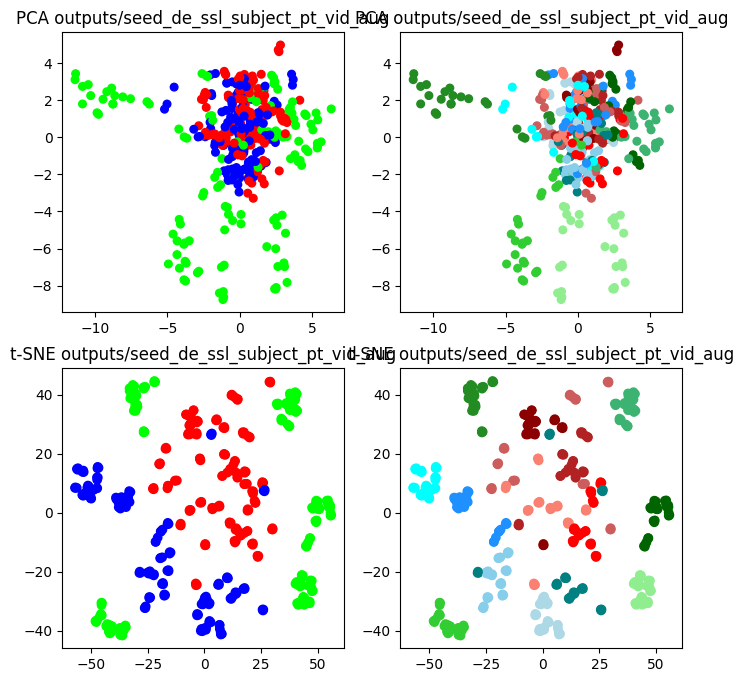

In [ ]:
from utils.visualization import plot_pca_tsne_pids
# Visualize embeddings
# One color mean one positive pair
plot_pca_tsne_pids(f"Pretrained embedding with augmentations", f"outputs/"+ num_exp+"_pt_vid_aug",
           model, test_loader_pt, num_video, num_elements=500, show_vid=True, device=device)

### Downstream task

In [ ]:
from models.cnn.classifier import get_sequential_classifier
ft_model = get_sequential_classifier(model, num_classes, emb_dim=emb_dim)

In [ ]:
# If needed layers freezing
# for param in ft_model[0].parameters():
#     param.requires_grad = False

In [ ]:
import torch.nn as nn

finetuning_epochs = 200
finetuning_wait_epochs = 25
sensitivity_early_stop = 1.0001
sensitivity_save_weights = 1.0001
save_weights_path = "model_weights/"
save_final_model_path = "model_weights/cnn_ft_"+num_exp+".pth"

optimizer = optim.Adam(ft_model.parameters(), lr=0.0001)
ft_scheduler = None
# ft_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1,step_size_up=5,mode="exp_range",gamma=0.85)

finetuning_criterion = nn.CrossEntropyLoss()
if num_classes == 2:
    finetuning_criterion = nn.BCEWithLogitsLoss()

ft_model = ft_model.to(device)

In [ ]:
from utils.test_run_classification import run_classification

_, losses, accs, ft_train_time, ft_test_time = run_classification(device, ft_model,
                   train_loader_ft, test_loader_ft,
                   optimizer, finetuning_criterion,

                   finetuning_epochs, finetuning_wait_epochs,
                   sensitivity_early_stop = sensitivity_early_stop,
                   sensitivity_save_weights = sensitivity_save_weights,
                   save_final_model_path=save_final_model_path, pt_scheduler =ft_scheduler)

# Print statistics
print()
print("First loss", round(losses[0], 4))
print("Best loss", round(min(losses), 4), "at epoch", np.argmin(losses))
print()
print("Stable accuracy", str(round(100*accs[np.argmin(losses)], 1)) + "%")
print("Best accuracy", str(round(100*max(accs), 1))+ "% at epoch", np.argmax(accs))
print("Train time", round(ft_train_time, 3), "sec \nTest time",  round(ft_test_time, 3), "sec")

100%|██████████| 1/1 [00:00<00:00, 12.07it/s, Loss=1.081552, AUC=0.385185, F1=0.335981]


Epoch 1
Train loss: 0.943272


100%|██████████| 1/1 [00:00<00:00, 32.77it/s, Loss=0.958110, AUC=0.607407, F1=0.568548]


The model weights were saved
Epoch 2
Train loss: 0.446274


100%|██████████| 1/1 [00:00<00:00, 42.10it/s, Loss=0.856640, AUC=0.725926, F1=0.720449]


The model weights were saved
Epoch 3
Train loss: 0.268218


100%|██████████| 1/1 [00:00<00:00, 42.36it/s, Loss=0.767324, AUC=0.807407, F1=0.806771]

The model weights were saved
Epoch 4


Train loss: 0.168319


100%|██████████| 1/1 [00:00<00:00, 41.64it/s, Loss=0.693177, AUC=0.807407, F1=0.806771]

The model weights were saved
Epoch 5


Train loss: 0.116712


100%|██████████| 1/1 [00:00<00:00, 41.97it/s, Loss=0.629787, AUC=0.837037, F1=0.836859]


The model weights were saved
Epoch 6
Train loss: 0.090672


100%|██████████| 1/1 [00:00<00:00, 36.88it/s, Loss=0.578637, AUC=0.851852, F1=0.851969]

The model weights were saved
Epoch 7


Train loss: 0.061828


100%|██████████| 1/1 [00:00<00:00, 41.80it/s, Loss=0.536983, AUC=0.859259, F1=0.859511]

The model weights were saved
Epoch 8


Train loss: 0.064563


100%|██████████| 1/1 [00:00<00:00, 30.36it/s, Loss=0.507512, AUC=0.866667, F1=0.867011]


The model weights were saved
Epoch 9
Train loss: 0.053513


100%|██████████| 1/1 [00:00<00:00, 39.35it/s, Loss=0.484187, AUC=0.859259, F1=0.859210]


The model weights were saved
Epoch 10
Train loss: 0.029273


100%|██████████| 1/1 [00:00<00:00, 42.12it/s, Loss=0.466166, AUC=0.859259, F1=0.859210]


The model weights were saved
Epoch 11
Train loss: 0.032036


100%|██████████| 1/1 [00:00<00:00, 39.10it/s, Loss=0.451504, AUC=0.866667, F1=0.866733]

The model weights were saved
Epoch 12


Train loss: 0.022944


100%|██████████| 1/1 [00:00<00:00, 39.72it/s, Loss=0.438181, AUC=0.866667, F1=0.866733]


The model weights were saved
Epoch 13
Train loss: 0.021874


100%|██████████| 1/1 [00:00<00:00, 42.01it/s, Loss=0.430376, AUC=0.866667, F1=0.866733]

The model weights were saved
Epoch 14


Train loss: 0.027757


100%|██████████| 1/1 [00:00<00:00, 42.08it/s, Loss=0.428402, AUC=0.866667, F1=0.866179]

The model weights were saved
Epoch 15


Train loss: 0.018873


100%|██████████| 1/1 [00:00<00:00, 39.25it/s, Loss=0.427092, AUC=0.859259, F1=0.858335]


The model weights were saved
Epoch 16
Train loss: 0.016224


100%|██████████| 1/1 [00:00<00:00, 42.04it/s, Loss=0.419863, AUC=0.859259, F1=0.858699]

The model weights were saved
Epoch 17


Train loss: 0.016226


100%|██████████| 1/1 [00:00<00:00, 38.10it/s, Loss=0.414446, AUC=0.866667, F1=0.866806]


The model weights were saved
Epoch 18
Train loss: 0.019005


100%|██████████| 1/1 [00:00<00:00, 26.62it/s, Loss=0.410304, AUC=0.874074, F1=0.874501]


The model weights were saved
Epoch 19
Train loss: 0.013195


100%|██████████| 1/1 [00:00<00:00, 39.22it/s, Loss=0.409217, AUC=0.874074, F1=0.874222]


The model weights were saved
Epoch 20
Train loss: 0.010689


100%|██████████| 1/1 [00:00<00:00, 42.54it/s, Loss=0.408909, AUC=0.866667, F1=0.867149]

The model weights were saved
Epoch 21


Train loss: 0.010081


100%|██████████| 1/1 [00:00<00:00, 35.03it/s, Loss=0.409520, AUC=0.866667, F1=0.867149]

Epoch 22


Train loss: 0.010664


100%|██████████| 1/1 [00:00<00:00, 40.08it/s, Loss=0.408189, AUC=0.866667, F1=0.866806]

The model weights were saved
Epoch 23


Train loss: 0.009675


100%|██████████| 1/1 [00:00<00:00, 41.75it/s, Loss=0.408213, AUC=0.866667, F1=0.866504]

Epoch 24


Train loss: 0.009774


100%|██████████| 1/1 [00:00<00:00, 34.98it/s, Loss=0.410942, AUC=0.859259, F1=0.859191]

Epoch 25


Train loss: 0.009304


100%|██████████| 1/1 [00:00<00:00, 26.35it/s, Loss=0.410150, AUC=0.866667, F1=0.866504]

Epoch 26


Train loss: 0.011273


100%|██████████| 1/1 [00:00<00:00, 40.89it/s, Loss=0.412238, AUC=0.859259, F1=0.859191]

Epoch 27


Train loss: 0.007801


100%|██████████| 1/1 [00:00<00:00, 38.86it/s, Loss=0.413946, AUC=0.874074, F1=0.873977]

Epoch 28


Train loss: 0.008153


100%|██████████| 1/1 [00:00<00:00, 28.67it/s, Loss=0.414762, AUC=0.874074, F1=0.873977]

Epoch 29


Train loss: 0.007442


100%|██████████| 1/1 [00:00<00:00, 42.91it/s, Loss=0.409662, AUC=0.866667, F1=0.866504]

Epoch 30


Train loss: 0.010167


100%|██████████| 1/1 [00:00<00:00, 38.49it/s, Loss=0.406285, AUC=0.866667, F1=0.866806]

The model weights were saved
Epoch 31


Train loss: 0.007209


100%|██████████| 1/1 [00:00<00:00, 44.31it/s, Loss=0.408419, AUC=0.866667, F1=0.866504]

Epoch 32


Train loss: 0.006047


100%|██████████| 1/1 [00:00<00:00, 42.57it/s, Loss=0.408978, AUC=0.859259, F1=0.859081]

Epoch 33


Train loss: 0.013609


100%|██████████| 1/1 [00:00<00:00, 19.62it/s, Loss=0.408012, AUC=0.866667, F1=0.866757]

Epoch 34


Train loss: 0.006202


100%|██████████| 1/1 [00:00<00:00, 23.40it/s, Loss=0.408738, AUC=0.866667, F1=0.866757]

Epoch 35


Train loss: 0.006100


100%|██████████| 1/1 [00:00<00:00, 28.37it/s, Loss=0.410001, AUC=0.859259, F1=0.859081]


Epoch 36
Train loss: 0.005663


100%|██████████| 1/1 [00:00<00:00, 26.58it/s, Loss=0.410124, AUC=0.859259, F1=0.859081]


Epoch 37
Train loss: 0.004743


100%|██████████| 1/1 [00:00<00:00, 28.69it/s, Loss=0.411783, AUC=0.859259, F1=0.859081]


Epoch 38
Train loss: 0.006050


100%|██████████| 1/1 [00:00<00:00, 26.08it/s, Loss=0.407932, AUC=0.881481, F1=0.881606]


Epoch 39
Train loss: 0.004659


100%|██████████| 1/1 [00:00<00:00, 28.51it/s, Loss=0.408996, AUC=0.866667, F1=0.866806]


Epoch 40
Train loss: 0.005730


100%|██████████| 1/1 [00:00<00:00, 22.45it/s, Loss=0.406603, AUC=0.851852, F1=0.851700]


Epoch 41
Train loss: 0.006338


100%|██████████| 1/1 [00:00<00:00, 25.95it/s, Loss=0.404027, AUC=0.851852, F1=0.851948]


The model weights were saved
Epoch 42
Train loss: 0.005237


100%|██████████| 1/1 [00:00<00:00, 29.50it/s, Loss=0.403249, AUC=0.866667, F1=0.866837]


The model weights were saved
Epoch 43
Train loss: 0.003923


100%|██████████| 1/1 [00:00<00:00, 29.20it/s, Loss=0.404563, AUC=0.859259, F1=0.859408]


Epoch 44
Train loss: 0.004677


100%|██████████| 1/1 [00:00<00:00, 21.74it/s, Loss=0.406020, AUC=0.859259, F1=0.859103]


Epoch 45
Train loss: 0.005334


100%|██████████| 1/1 [00:00<00:00, 27.04it/s, Loss=0.404992, AUC=0.851852, F1=0.851822]


Epoch 46
Train loss: 0.005904


100%|██████████| 1/1 [00:00<00:00, 32.12it/s, Loss=0.409656, AUC=0.866667, F1=0.866504]


Epoch 47
Train loss: 0.003531


100%|██████████| 1/1 [00:00<00:00, 22.19it/s, Loss=0.408974, AUC=0.866667, F1=0.866359]

Epoch 48


Train loss: 0.003949


100%|██████████| 1/1 [00:00<00:00, 26.64it/s, Loss=0.407686, AUC=0.866667, F1=0.866359]

Epoch 49


Train loss: 0.004001


100%|██████████| 1/1 [00:00<00:00, 23.13it/s, Loss=0.407203, AUC=0.859259, F1=0.859103]

Epoch 50


Train loss: 0.004226


100%|██████████| 1/1 [00:00<00:00, 24.37it/s, Loss=0.408338, AUC=0.859259, F1=0.859103]

Epoch 51


Train loss: 0.003239


100%|██████████| 1/1 [00:00<00:00, 22.17it/s, Loss=0.408735, AUC=0.866667, F1=0.866359]

Epoch 52


Train loss: 0.005010


100%|██████████| 1/1 [00:00<00:00, 36.95it/s, Loss=0.406043, AUC=0.859259, F1=0.859103]


Epoch 53
Train loss: 0.003197


100%|██████████| 1/1 [00:00<00:00, 38.69it/s, Loss=0.405993, AUC=0.844444, F1=0.844511]

Epoch 54


Train loss: 0.006187


100%|██████████| 1/1 [00:00<00:00, 37.50it/s, Loss=0.407494, AUC=0.859259, F1=0.859103]


Epoch 55
Train loss: 0.003560


100%|██████████| 1/1 [00:00<00:00, 37.17it/s, Loss=0.403718, AUC=0.851852, F1=0.851989]

Epoch 56


Train loss: 0.003071


100%|██████████| 1/1 [00:00<00:00, 31.99it/s, Loss=0.403836, AUC=0.851852, F1=0.851634]

Epoch 57


Train loss: 0.005315


100%|██████████| 1/1 [00:00<00:00, 41.70it/s, Loss=0.408313, AUC=0.844444, F1=0.844511]

Epoch 58


Train loss: 0.003569


100%|██████████| 1/1 [00:00<00:00, 39.54it/s, Loss=0.409573, AUC=0.844444, F1=0.845018]

Epoch 59


Train loss: 0.006763


100%|██████████| 1/1 [00:00<00:00, 37.81it/s, Loss=0.411427, AUC=0.851852, F1=0.852591]

Epoch 60


Train loss: 0.005386


100%|██████████| 1/1 [00:00<00:00, 38.42it/s, Loss=0.411941, AUC=0.837037, F1=0.837307]

Epoch 61


Train loss: 0.002468


100%|██████████| 1/1 [00:00<00:00, 41.80it/s, Loss=0.409187, AUC=0.859259, F1=0.859446]

Epoch 62


Train loss: 0.004372


100%|██████████| 1/1 [00:00<00:00, 36.76it/s, Loss=0.409810, AUC=0.844444, F1=0.844294]

Epoch 63


Train loss: 0.005109


100%|██████████| 1/1 [00:00<00:00, 40.13it/s, Loss=0.416533, AUC=0.851852, F1=0.852267]

Epoch 64


Train loss: 0.002219


100%|██████████| 1/1 [00:00<00:00, 41.64it/s, Loss=0.411565, AUC=0.844444, F1=0.844429]

Epoch 65


Train loss: 0.002222


100%|██████████| 1/1 [00:00<00:00, 36.26it/s, Loss=0.410940, AUC=0.859259, F1=0.858946]

Epoch 66


Train loss: 0.002443


100%|██████████| 1/1 [00:00<00:00, 37.42it/s, Loss=0.410018, AUC=0.844444, F1=0.844429]

Epoch 67


Train loss: 0.002115


100%|██████████| 1/1 [00:00<00:00, 42.82it/s, Loss=0.408994, AUC=0.851852, F1=0.851700]

The finetuning starts to overfit, so stop the process
The best loss is 0.40325 at epoch 42

First loss 1.0816
Best loss 0.4032 at epoch 42

Stable accuracy 86.7%
Best accuracy 88.1% at epoch 38
Train time 0.119 sec 
Test time 0.035 sec


In [ ]:
from utils.predict import print_classification_report

# Load best model
ft_model.load_state_dict(torch.load(save_final_model_path, weights_only=True))

print_classification_report(ft_model, test_loader_ft, num_classes, device='cpu')

              precision    recall  f1-score   support

    negative       0.87      0.89      0.88        45
     neutral       0.83      0.87      0.85        45
    positive       0.90      0.84      0.87        45

    accuracy                           0.87       135
   macro avg       0.87      0.87      0.87       135
weighted avg       0.87      0.87      0.87       135



### Quantization

In [ ]:
from utils.quantize import quantize_model
device='cpu'
model_quantized = quantize_model(ft_model.to(device), test_loader_ft, device=device , backend="fbgemm")
model_quantized

GraphModule(
  (0): Module(
    (cn): Module(
      (0): QuantizedConv2d(5, 64, kernel_size=(1, 3), stride=(1, 1), scale=0.06511269509792328, zero_point=67, padding=(0, 1))
      (1): QuantizedLeakyReLU(negative_slope=0.01)
      (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (3): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): QuantizedDropout(p=0.2, inplace=False)
      (5): QuantizedConv2d(64, 128, kernel_size=(1, 3), stride=(1, 1), scale=0.06424271315336227, zero_point=65, padding=(0, 1))
      (6): QuantizedLeakyReLU(negative_slope=0.01)
      (7): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      (8): QuantizedBatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): QuantizedDropout(p=0.25, inplace=False)
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): QuantizedLinear(in_features=15872, out_featur

In [ ]:
# Evaluate quantization
from utils.quantize import eval_quantization
eval_quantization(model_quantized, test_loader_ft, num_classes, device)

Model size: 2.15 MB
Total Trainable Params: 28160
More detailed parameters distribution:
+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| 0.cn.0.weight |    960     |
|  0.cn.0.bias  |     64     |
| 0.cn.3.weight |     64     |
|  0.cn.3.bias  |     64     |
| 0.cn.5.weight |   24576    |
|  0.cn.5.bias  |    128     |
| 0.cn.8.weight |    128     |
|  0.cn.8.bias  |    128     |
|    3.weight   |    1024    |
|     3.bias    |    1024    |
+---------------+------------+



100%|██████████| 1/1 [00:00<00:00, 13.21it/s, Loss=0.405816, AUC=0.844444, F1=0.844804]

Loss: 0.41
Accuracy: 0.84
Processing time: 0.08055281639099121 sec


In [ ]:
# Compare initial model with its quantized version
from utils.quantize import compare_quantization
compare_quantization(ft_model, model_quantized, test_loader_ft, num_classes, device='cpu')

Model size changed from 8.39 MB to 2.15 MB
The size of the model has decreased by 3.9 times
Number of trainable parameters changed from 2195331 to 2432, or by 902.69 times


100%|██████████| 1/1 [00:00<00:00, 15.59it/s, Loss=0.405816, AUC=0.844444, F1=0.844804]

Loss changed on -0.0 times
Accuracy changed on 2.0%
Processing time changed by 2.64 times


In [ ]:
# Reset cache
import gc

ft_model.to("cpu")
del ft_model
model.to("cpu")
del model
for _ in range(30):
    gc.collect()
for _ in range(100000):
    torch.cuda.empty_cache()